# ***Set parameters***

In [139]:
__algo__ = "Spectral"             #Name of the Clustering algorithm
__emb__ = "glove"                 #Name of the Word Embeddings used (glove, w2v, ftt), MUST set directory below
__sentemb__ = "pmeans5"           #Name of Sentence Embedding algorithm used
recnum = 30000                     #Number of records to be read from files
k = 350                            #Number of Clusters
usesqrt = False                   #Set value of k to sqrt of recnum, overrides k
randomsample = False              #Random Sampling to be True/False for records which are read
embedDir = "../MegaSentEmbs/"     #Directory where embeddings are saved for that selected embedding
modelDir = "../models/"           #Directory where models are saved
megadfDir = "../MegaDfs/"         #Directory Where Megadf is to be saved
plotDir = "../plots/"             #Directory where plots are saved
metadataDir = "../modelMetaData/" #Directory where performance and distribution params are to be stored
dumpDir = "../dump/"              #Directory where test outcomes are saved

# Actual Code

### imports and time

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import os, subprocess, sys
import datetime, time
import pickle

### File Settings

In [141]:
oldlist = os.listdir(embedDir)
filelist = sorted([embedDir+f for f in oldlist if f[-3:]=="pkl"])
filenum = len(filelist)
smalllist = filelist[:filenum]
print("Length of Smalllist: ", len(smalllist))

Length of Smalllist:  116


### Number of Records
It is Recommended to Set this at the top parameters

In [142]:
recnum = recnum

### Read all the pandas dataframes

In [143]:
%%time
megadf = pd.DataFrame()

if randomsample == True:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
    megadf = megadf.sample(recnum, random_state=42)
else:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
        if megadf.shape[0] >= recnum:
            megadf = megadf[:recnum]
            break

print("megadf.shape: ", megadf.shape)

randomsample:  False
megadf.shape:  (30000, 4)
CPU times: user 652 ms, sys: 75.8 ms, total: 728 ms
Wall time: 729 ms


In [144]:
predata = megadf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(30000, 250)


### Number of Clusters
It is Recommended to Set this at the top parameters

In [145]:
if usesqrt == True:
    print("usesqrt: ", usesqrt)
    sqrt_k = int(np.sqrt(data.shape[0]))
    k = int(sqrt_k)
else:
    print("usesqrt: ", usesqrt)
    k = k
print("k: ", k)

usesqrt:  False
k:  350


## Clustering
Please modify the functions here to change algorithm

In [146]:
%%time
print("Starting Clustering Process")
start_time = time.time()
model = cluster.SpectralClustering(n_clusters=k, eigen_solver="arpack", random_state=42, affinity='nearest_neighbors', n_neighbors=10,  n_init = 20, n_jobs=-1)
model.fit(data)
end_time = time.time()
timetrain = round(end_time-start_time, 2)
print("done! {}".format(timetrain))
print("k_means.fit(data) Done!")

Starting Clustering Process


/home/devashish/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


done! 2540.0
k_means.fit(data) Done!
CPU times: user 1h 26min 36s, sys: 1min 8s, total: 1h 27min 44s
Wall time: 42min 20s


### Saving the output data into vars

In [147]:
affinity = model.affinity_matrix_
labels = model.labels_
megadf["clusterlabel"]=labels
affinityDF = pd.DataFrame(affinity)


## Plotting

Text(0.5, 1.0, 'Spectral with k=350 records=30000 features=250 using glove')

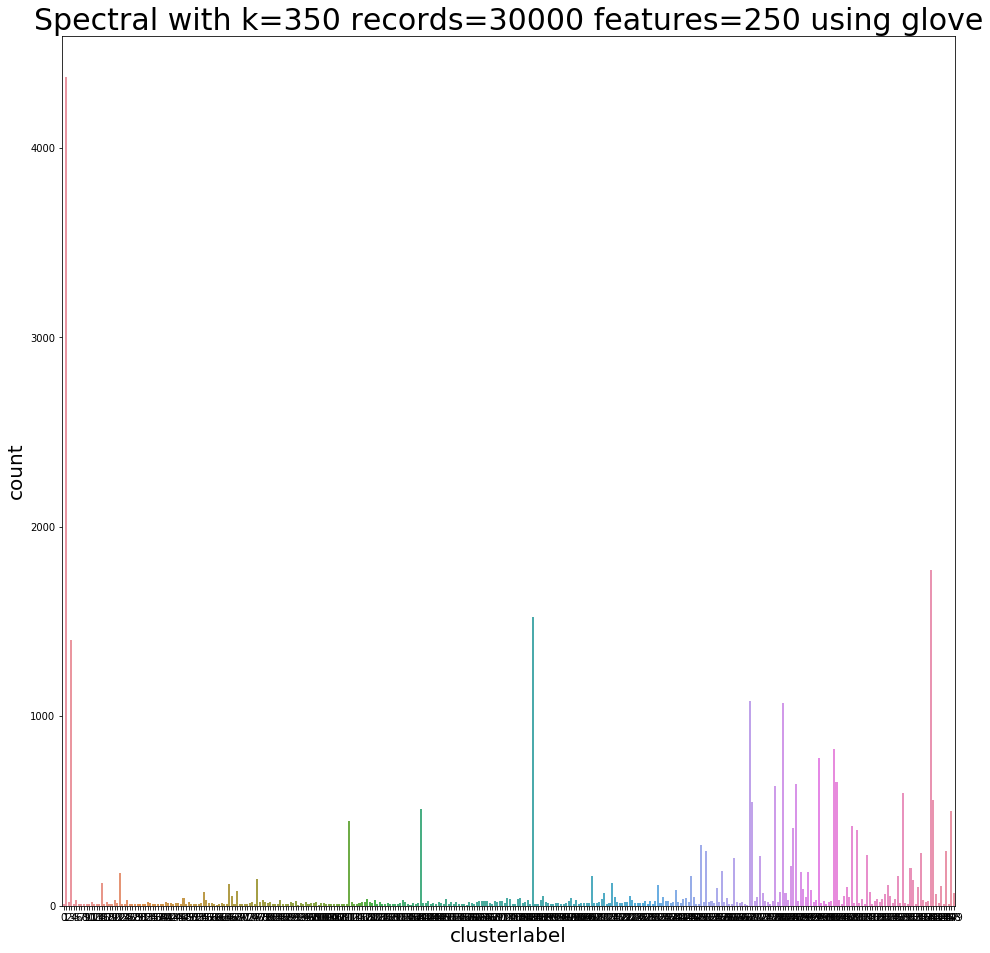

In [148]:
plt.figure(figsize=(16,16))
titlestring = "{} with k={} records={} features={} using {}".format(__algo__, k, data.shape[0], data.shape[1], __emb__)
snsplot = sns.countplot("clusterlabel", data=megadf)
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 30}
    )

### *Name given to saved files*

In [149]:
features = data.shape[1]
records = data.shape[0]
name = "{}_{}_{}_K{}_R{}_F{}".format(__algo__, __emb__, __sentemb__, k, records, features)
name

'Spectral_glove_pmeans5_K350_R30000_F250'

### Saving Data

Save model

In [150]:
modelname = "{}_model.pkl".format(name)
pickle.dump(model, open(modelDir + modelname, 'wb'))

Save Plot

In [151]:
snspltname = "{}_plt.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)

Save Megadf

In [152]:
clusterdfname = "{}_clustered_megadf.pkl".format(name)
megadf.to_pickle(megadfDir + clusterdfname)

Save Affinity

In [153]:
affinityDF = pd.DataFrame(affinity)
affinityDFname = "{}_affinity.pkl".format(name)
affinityDF.to_pickle(megadfDir + affinityDFname)
print(affinityDF.shape)
print(affinityDF.columns)

(30000, 1)
RangeIndex(start=0, stop=1, step=1)


#### Open dataframe to test

In [154]:
sub = megadf.loc[:, ["id", "title", "abstract", "clusterlabel"]]
sub.tail()

,id,title,abstract,clusterlabel
29995,1639102,Age of onset of schizophrenia in siblings: A t...,"[original, article, found, http, www, scienced...",244
29996,1639103,Reducing persistent auditory hallucinations by...,"[copyright, british, psychological, society, f...",262
29997,1639104,Investigating Visual Knowledge in Dementia of ...,"[original, article, found, http, www, scienced...",244
29998,1639105,Monaural ear advantages in simple and choice r...,"[original, article, found, http, www, scienced...",244
29999,1639106,Routes to action in reaction time tasks,"[original, publication, available, www, spring...",180


In [155]:
megadf.columns

Index(['id', 'title', 'abstract', 'embedding', 'clusterlabel'], dtype='object')

# Performance Testing and Distribution


In [156]:
metadata = pd.DataFrame(columns=["Name", "Algo", "WordEmb", "SentEmb", "K", "R", "F", "SS", "CSavg", "CSmin", "CSmax", "T2Pavg", "T2LM", "T2LMP", "MEM"])

In [157]:
metadict = {
    "Name":None,                     #Name of the save file prefix
    "Algo":None,                     #Name of the Clustering algorithm
    "WordEmb":None,                  #Name of the Word Embeddings used (glove, w2v, ftt)
    "SentEmb":None,                  #Name of Sentence Embedding algorithm used 
    "K":None, "R":None, "F":None,    #Number of clusters, records and fetures
    "T2T":None,                      #Time required to train model
    "SS":None,                       #Silhoutte Score
    "DBS":None,                      #Davis Bouldin Score
    "CSavg":None,                    #Average Cluster Size
    "CSmin":None,                    #Minimum Cluster Size
    "CSmax":None,                    #Maximum Cluster Size
    "T2Pavg":None,                   #Average Time To Predict cluster of one record
    "T2LM":None,                     #Average Time to Load Model
    "T2LMP":None,                    #Amortized time to Predict after loading the model
    "MEM":None                      #Memory used by the Model
    }
metadict

{'Name': None,
 'Algo': None,
 'WordEmb': None,
 'SentEmb': None,
 'K': None,
 'R': None,
 'F': None,
 'T2T': None,
 'SS': None,
 'DBS': None,
 'CSavg': None,
 'CSmin': None,
 'CSmax': None,
 'T2Pavg': None,
 'T2LM': None,
 'T2LMP': None,
 'MEM': None}

In [158]:
metadict["Name"]=name
metadict["Algo"]=__algo__
metadict["WordEmb"]=__emb__
metadict["SentEmb"]=__sentemb__
metadict["K"]=k
metadict["R"]=recnum
metadict["F"]=features
metadict

{'Name': 'Spectral_glove_pmeans5_K350_R30000_F250',
 'Algo': 'Spectral',
 'WordEmb': 'glove',
 'SentEmb': 'pmeans5',
 'K': 350,
 'R': 30000,
 'F': 250,
 'T2T': None,
 'SS': None,
 'DBS': None,
 'CSavg': None,
 'CSmin': None,
 'CSmax': None,
 'T2Pavg': None,
 'T2LM': None,
 'T2LMP': None,
 'MEM': None}

#### Time to train

In [159]:
metadict["T2T"]=timetrain

#### Scores

In [160]:
ss = silhouette_score(data, labels, metric = 'euclidean')
dbs = davies_bouldin_score(data, labels)
metadict["SS"]=ss
metadict["DBS"]=dbs

#### Cluster Size

In [161]:
clusterdata = megadf.groupby("clusterlabel", as_index=True).size().reset_index(name="count")
clusterdata.head()

,clusterlabel,count
0,0,9
1,1,4372
2,2,19
3,3,1401
4,4,9


In [162]:
clusterdfname = "{}_clustered_counts.pkl".format(name)
clusterdata.to_pickle(megadfDir + clusterdfname)

In [163]:
countdata = clusterdata.groupby("count").size().reset_index(name="clusters")
display(countdata.head(3))
display(countdata.tail(3))

,count,clusters
0,5,3
1,6,3
2,7,11


,count,clusters
95,1522,1
96,1772,1
97,4372,1


In [164]:
metadict["CSmax"] = max(clusterdata["count"])
metadict["CSmin"] = min(clusterdata["count"])
metadict["CSavg"] = np.mean(clusterdata["count"])

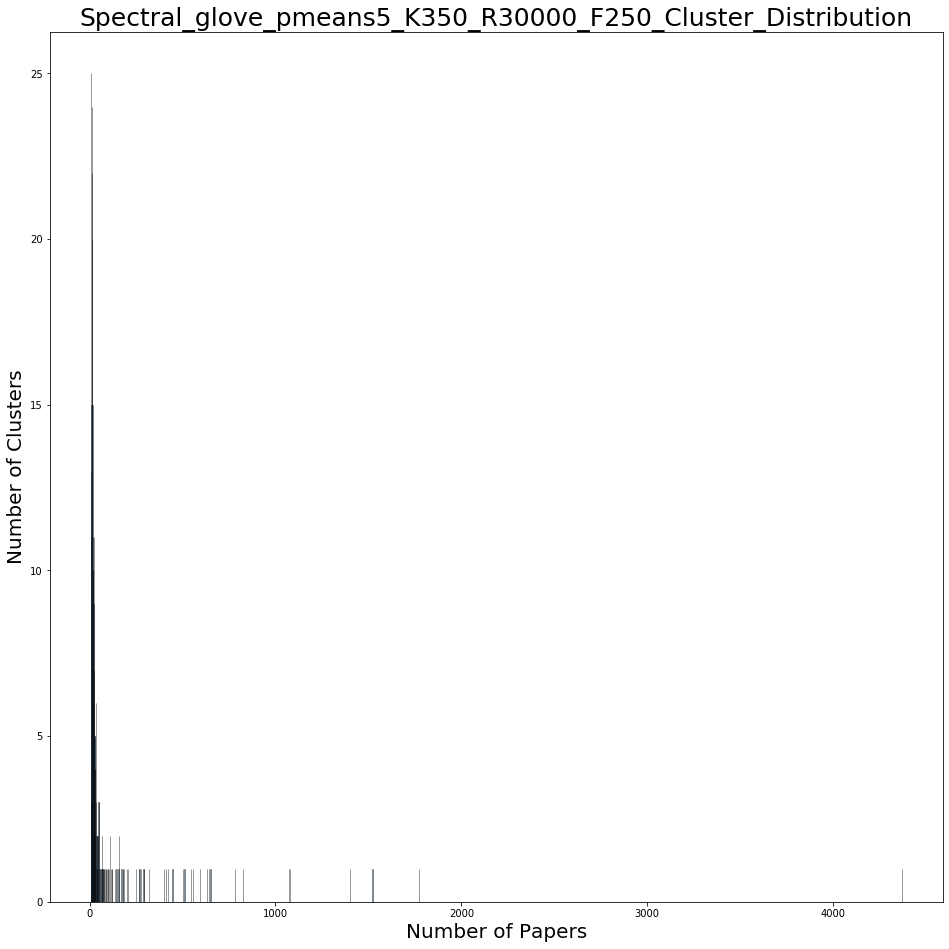

In [165]:
%matplotlib inline
plt.figure(figsize=(16,16))

sns.axes_style("whitegrid", {"axes.grid":True, 
                            'axes.spines.left': False,
                             'axes.spines.bottom': False,
                             'axes.spines.right': False,
                             'axes.spines.top': False})


titlestring = "{}_Cluster_Distribution".format(name)
snsplot = sns.distplot(clusterdata["count"], kde=False, bins=max(clusterdata["count"]),
                      hist_kws={'edgecolor':'black'},)
snsplot.set(xlabel="Number of Papers", ylabel="Number of Clusters")
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 25}
    )
plt.show()



In [166]:
snspltname = "{}_Cluster_Distribution.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)

#### Prediction Time Performance

In [167]:
testdf = pd.DataFrame()
if recnum < 2000:
    samplenum = int(recnum / 10)
else:
    samplenum = 2000

for f in smalllist:
    tempdf = pd.read_pickle(f)
    testdf = megadf.append(tempdf, ignore_index = True, sort = False)
testdf = testdf.sample(samplenum, random_state=int(time.time()%100000))
predata = testdf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(2000, 250)


In [168]:
# print("Starting Predicting Performance")
# testmodel = model
# start_time = time.time()
# for d in data:
#     lb = testmodel.predict(d)
# end_time = time.time()
# timetest = end_time-start_time
# avgtime = timetest/data.shape[0]
# print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
avgtime = timetrain
metadict["T2Pavg"]=avgtime

In [169]:
print("Starting Loading Performance")
loadruns = 50
start_time = time.time()
for i in range(loadruns):
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/loadruns
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LM"] = avgtime
avgtime

Starting Loading Performance
Avgtime: 0.0027181291580200195 Totaltime: 0.13590645790100098


0.0027181291580200195

In [170]:
# print("Starting Amortized Performance")
# loadruns = 5
# avglist = []

# for i in range(loadruns):
#     start_time = time.time()
#     testmodel = pickle.load(open(modelDir + modelname, 'rb'))
#     for d in data:
#         lb = testmodel.predict(d)
#     end_time = time.time()
#     timetest = (end_time-start_time)/data.shape[0]
#     avglist.append(timetest)

# timetest = np.sum(avglist)
# avgtime = np.mean(avglist)
# print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
avgtime = timetrain
metadict["T2LMP"] = avgtime
avgtime

2540.0

In [171]:
modelsize = sys.getsizeof(pickle.dumps(model))
print("modelsize:", modelsize, "bytes")
metadict["MEM"]=modelsize

modelsize: 6110417 bytes


In [172]:
metadict

{'Name': 'Spectral_glove_pmeans5_K350_R30000_F250',
 'Algo': 'Spectral',
 'WordEmb': 'glove',
 'SentEmb': 'pmeans5',
 'K': 350,
 'R': 30000,
 'F': 250,
 'T2T': 2540.0,
 'SS': 0.004851195785810773,
 'DBS': 2.335602826496675,
 'CSavg': 85.71428571428571,
 'CSmin': 5,
 'CSmax': 4372,
 'T2Pavg': 2540.0,
 'T2LM': 0.0027181291580200195,
 'T2LMP': 2540.0,
 'MEM': 6110417}

In [173]:
metadata = metadata.append(metadict, ignore_index=True)
metadata

,Name,Algo,WordEmb,SentEmb,K,R,F,SS,CSavg,CSmin,CSmax,T2Pavg,T2LM,T2LMP,MEM,DBS,T2T
0,Spectral_glove_pmeans5_K350_R30000_F250,Spectral,glove,pmeans5,350,30000,250,0.004851,85.714286,5,4372,2540.0,0.002718,2540.0,6110417,2.335603,2540.0


In [174]:
metadataname = "{}_metadata.pkl".format(name)
metadata.to_pickle(metadataDir + metadataname)